In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
def calculate_rsi(data, period=14):
    # Step 1: Calculate the daily price changes
    delta = data['Close'].diff()

    # Step 2: Separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    # Step 3: Calculate average gain and loss (initial 14 periods)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # Step 4: Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Step 5: Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [ ]:
# Download data
ticker = yf.Ticker('SPY')
start_date = '2015-01-01'
end_date = '2024-01-01'
data = ticker.history(start=start_date, end=end_date, period='1d')

# Create target first and drop NaN values
data['Target'] = data['Close'].shift(-1)

# Clean data
try:
  data.drop(['Dividends', 'Stock Splits', 'Capital Gains'], inplace=True, axis=1)
except KeyError:
  print('Columns already dropped')

# Up: 1, Down: 0
data['Up_or_down'] = np.where(data['Target'] > data['Close'], 1, 0)

# calcualting features
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI'] = calculate_rsi(data, period=14)

# dropping missing values
data.dropna(inplace=True)

print(data.head())
print(data.tail())

                                 Open        High         Low       Close  \
Date                                                                        
2015-03-16 00:00:00-04:00  174.252791  175.921891  173.536251  175.829163   
2015-03-17 00:00:00-04:00  175.078925  175.694298  174.480402  175.306534   
2015-03-18 00:00:00-04:00  174.826025  178.096800  174.176926  177.413986   
2015-03-19 00:00:00-04:00  176.992529  177.422445  176.208549  176.604752   
2015-03-20 00:00:00-04:00  177.570855  178.680089  177.384571  178.163574   

                              Volume      Target  Up_or_down      EMA_50  \
Date                                                                       
2015-03-16 00:00:00-04:00  136099200  175.306534           0  174.544795   
2015-03-17 00:00:00-04:00   94510400  177.413986           1  174.574667   
2015-03-18 00:00:00-04:00  228808500  176.604752           0  174.686013   
2015-03-19 00:00:00-04:00  117917300  178.163574           1  174.761258   
2015

In [ ]:
# features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_50', 'SMA_50', 'RSI']
X = data[features]
y = data['Up_or_down']

#splitting data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# selecitng model
model = RandomForestClassifier(n_estimators=200, max_depth=20,
                                     min_samples_split=100, random_state=42)

# training model
model.fit(X_train, y_train)

# predicting values
predicted = model.predict(X_test)

In [ ]:
outcome = pd.DataFrame({'Actual': y_test, 'Predicted': predicted})
print(outcome)

                           Actual  Predicted
Date                                        
2021-01-08 00:00:00-05:00       0          1
2020-10-29 00:00:00-04:00       0          1
2017-07-05 00:00:00-04:00       0          1
2021-03-24 00:00:00-04:00       1          1
2020-02-04 00:00:00-05:00       1          1
...                           ...        ...
2022-12-30 00:00:00-05:00       0          0
2019-06-21 00:00:00-04:00       0          0
2016-06-03 00:00:00-04:00       1          0
2020-06-16 00:00:00-04:00       0          1
2017-09-12 00:00:00-04:00       1          1

[443 rows x 2 columns]


In [ ]:
print('Accuracy:', accuracy_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print('F1 score:', f1_score(y_test, predicted))

Accuracy: 0.5485327313769752
Precision: 0.5718954248366013
Recall: 0.7172131147540983
F1 score: 0.6363636363636364


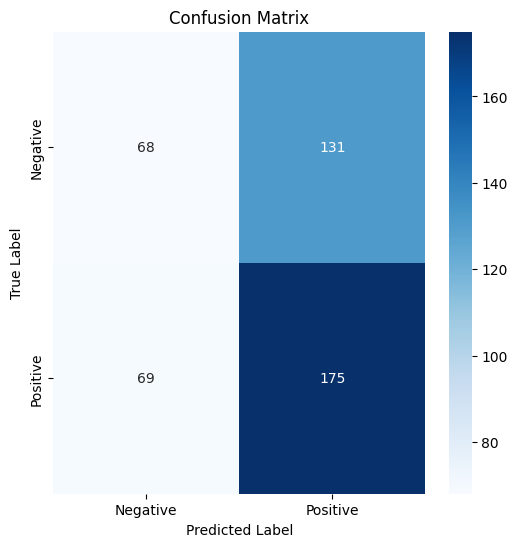

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, predicted)
class_names = ['Negative', 'Positive']

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(cm)

[[ 68 131]
 [ 69 175]]
